In [66]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [67]:
turbine_readings = pd.read_csv('./data/WindData_scrubbed.csv')
print(turbine_readings.shape)

(2600, 86)


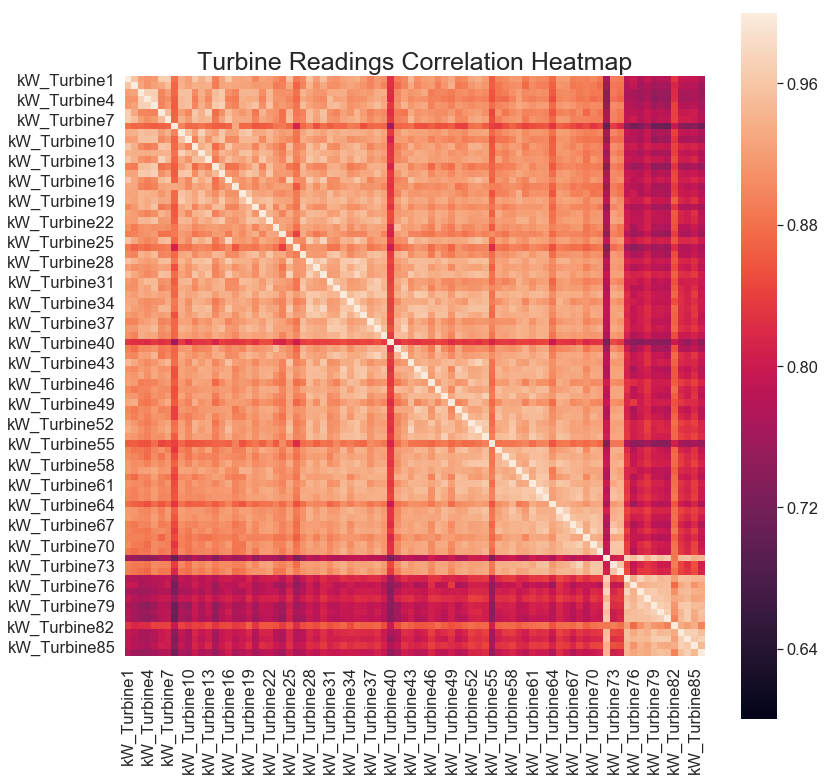

In [111]:
fig, ax = plt.subplots(figsize=(13,13))
corr = turbine_readings.corr()
sns.set(font_scale=1.5)
sns.heatmap(corr, square=True, ax=ax, vmin=.6)
plt.title("Turbine Readings Correlation Heatmap", fontsize=25)
plt.show()

In [56]:
start_datetime = datetime(2016, 1, 1, 0, 0, 0)
print(start_datetime)
datetime_list = []
for i in range(turbine_readings.shape[0]):
    datetime_list.append(start_datetime)
    start_datetime += timedelta(hours=1.68)

print(len(datetime_list))
turbine_readings["timestamp"] = datetime_list

2016-01-01 00:00:00
2600


In [57]:
turbine_readings.to_csv("./data/turbine_readings.csv", index=False)
pickle_out = open("./data/turbine_readings.pickle", "wb")
pickle.dump(turbine_readings, pickle_out)
pickle_out.close()
turbine_readings.tail()

,kW_Turbine1,kW_Turbine2,kW_Turbine3,kW_Turbine4,kW_Turbine5,kW_Turbine6,kW_Turbine7,kW_Turbine8,kW_Turbine9,kW_Turbine10,...,kW_Turbine78,kW_Turbine79,kW_Turbine80,kW_Turbine81,kW_Turbine82,kW_Turbine83,kW_Turbine84,kW_Turbine85,kW_Turbine86,timestamp
2595,35.02,34.15,48.33,34.822,28.674,46.79,34.17,63.060,74.11,64.547,...,42.765,22.08,53.92,63.965,9.36,59.65,58.16,51.00,57.81,2016-06-30 15:36:00
2596,44.99,23.61,37.57,35.266,33.167,35.87,48.58,71.635,44.70,70.420,...,49.163,45.69,76.75,63.862,68.29,60.42,69.75,59.13,78.24,2016-06-30 17:16:48
2597,30.98,10.26,28.07,35.710,37.660,50.95,56.53,80.210,28.30,30.010,...,55.560,54.42,54.88,63.760,75.37,36.97,66.78,46.53,64.05,2016-06-30 18:57:36
2598,58.29,17.14,29.35,25.500,21.590,66.89,101.01,88.785,53.31,29.380,...,59.440,42.71,54.71,59.170,66.25,67.74,60.65,57.02,48.53,2016-06-30 20:38:24
2599,51.20,27.58,48.42,42.570,50.980,81.07,128.53,97.360,75.69,45.890,...,47.190,49.66,42.54,49.510,57.88,68.84,49.53,61.59,53.10,2016-06-30 22:19:12


In [58]:
feature_dict = {"AWND" : "Average Windspeed (mph)",
                "WSF5" : "Fastest 5-second wind speed (mph)",
                "WSF2" : "Fastest 2-minute wind speed (mph)",
                "WDF2" : "Direction of fastest 2-minute wind (azimuth)",
                "WDF5" : "Direction of fastest 5-second wind (azimuth)"}

In [59]:
turbine_names = list(turbine_readings.columns.values)
turbine_names.remove("timestamp")
random_turbines = np.random.choice(turbine_names, size=10, replace=False)
print(random_turbines)
traces = []

for turbine in random_turbines:
    trace = go.Scatter(x = turbine_readings["timestamp"],
                       y = turbine_readings[turbine],
                       mode = 'lines',
                       name = turbine)
    traces.append(trace)

layout = go.Layout(
    title="Random Sample of Turbine Readings | Time Series",
    yaxis=dict(
    title="Turbine Reading (kWh)"))
    
fig = go.Figure(data=traces, layout=layout)   
py.iplot(fig)

['kW_Turbine44' 'kW_Turbine76' 'kW_Turbine80' 'kW_Turbine14' 'kW_Turbine1'
 'kW_Turbine2' 'kW_Turbine81' 'kW_Turbine22' 'kW_Turbine17' 'kW_Turbine56']


In [60]:
turbine_readings = turbine_readings.melt(id_vars="timestamp", var_name="turbine_num", value_name="reading")

In [61]:
turbine_readings["date"] = turbine_readings["timestamp"].dt.date
print(turbine_readings.head())

            timestamp  turbine_num  reading        date
0 2016-01-01 00:00:00  kW_Turbine1   316.71  2016-01-01
1 2016-01-01 01:40:48  kW_Turbine1   282.87  2016-01-01
2 2016-01-01 03:21:36  kW_Turbine1   275.02  2016-01-01
3 2016-01-01 05:02:24  kW_Turbine1   360.92  2016-01-01
4 2016-01-01 06:43:12  kW_Turbine1   386.46  2016-01-01


In [62]:
daily_mean_turbine_reading = turbine_readings.groupby(["date", "turbine_num"], as_index=False)["reading"].mean()
daily_mean_turbine_reading.head()

station_files = ["./data_2016/weather_2016/projects/Alta X/GHCND_USW00003159/",
                 "./data_2016/weather_2016/projects/Alta X/GHCND_USW00053144/",
                 "./data_2016/weather_2016/projects/Alta XI/GHCND_USW00023187/"]

feature_files = []

for station in station_files:
    for filename in os.listdir(station):
        if filename.endswith(".csv"):
            feature_files.append(station+filename)

for feature_file in feature_files:
    df = pd.read_csv(feature_file)
    df["date"] = df["date"].str.split("T", expand=True)[0]
    df["date"] = pd.to_datetime(df["date"]).dt.date
    df.rename(columns={"value": (df["station"][0] + "|" + df["datatype"][0])}, inplace=True)
    df = df[["date", (df["station"][0] + "|" + df["datatype"][0])]]
    daily_mean_turbine_reading = pd.merge(daily_mean_turbine_reading, df, on="date", how="left")

print(daily_mean_turbine_reading.head())

         date   turbine_num     reading  GHCND:USW00003159|AWND  \
0  2016-01-01   kW_Turbine1  837.602667                     4.9   
1  2016-01-01  kW_Turbine10  759.655333                     4.9   
2  2016-01-01  kW_Turbine11  544.115333                     4.9   
3  2016-01-01  kW_Turbine12  823.235333                     4.9   
4  2016-01-01  kW_Turbine13  789.448667                     4.9   

   GHCND:USW00003159|TMAX  GHCND:USW00003159|TMIN  GHCND:USW00003159|WDF2  \
0                    47.0                    14.0                      50   
1                    47.0                    14.0                      50   
2                    47.0                    14.0                      50   
3                    47.0                    14.0                      50   
4                    47.0                    14.0                      50   

   GHCND:USW00003159|WDF5  GHCND:USW00003159|WSF2  GHCND:USW00003159|WSF5  \
0                    70.0                    10.1        

In [63]:
traces = []
for turbine in random_turbines:
    filtered_turbine = daily_mean_turbine_reading.loc[daily_mean_turbine_reading["turbine_num"] == turbine]
    trace = go.Scatter(x = filtered_turbine["date"],
                       y = filtered_turbine["reading"],
                       mode = 'lines',
                       name = turbine)
    traces.append(trace)

layout = go.Layout(
    title="Random Sample of Turbine Readings | Time Series Plot (Downsampled)",
    yaxis=dict(
    title="Turbine Reading (kWh)"))
    
fig = go.Figure(data=traces, layout=layout)   
py.iplot(fig)

In [64]:
random_turbines = np.random.choice(turbine_names, size=1, replace=False)
print(random_turbines)
filtered_turbine = daily_mean_turbine_reading.loc[daily_mean_turbine_reading["turbine_num"] == turbine]

features_list = ["AWND", "WSF5", "WSF2", "WDF5", "WDF2"]

for feature in features_list:
    traces = []
    for turbine in random_turbines:
        for column in filtered_turbine:
            if column.endswith(feature):
                trace = go.Scatter(x=filtered_turbine[column],
                                   y=filtered_turbine["reading"],
                                   name=column,
                                   mode='markers')
                traces.append(trace)
                
    layout = go.Layout(
    title="Turbine Readings vs. " + feature_dict[feature],
    yaxis=dict(
        title="Turbine Reading (kWh)"),
    xaxis=dict(
        title=feature_dict[feature]))
    
    fig = go.Figure(data=traces, layout=layout)   
    py.iplot(fig)

['kW_Turbine39']


In [112]:
stations = ["GHCND:USW00003159|", "GHCND:USW00053144|", "GHCND:USW00023187|"]
filtered_turbine = daily_mean_turbine_reading.loc[daily_mean_turbine_reading["turbine_num"] == random_turbines[0]]

for feature in features_list:
    traces = []
    for station in stations:
        try:
            trace = go.Scatter(x = filtered_turbine["date"],
                               y = filtered_turbine[station+feature],
                               mode = 'lines',
                               name = station+feature)
            traces.append(trace)
        except:
            print("Feature not available.")
    
        layout = go.Layout(
        title=feature_dict[feature] + " Time Series",
        yaxis=dict(
            title='Average Wind Speed (mph)'))
    
    fig = go.Figure(data=traces, layout=layout)
    py.iplot(fig)